<a href="https://colab.research.google.com/github/tvphuong2/finbros/blob/main/Finpros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dự đoán biến động giá cổ phiếu

Theo em hiểu thì dự đoán biến động là dự đoán xu hướng tăng hoặc giảm của một mã cổ phiếu nào đó vào khoảng thời gian tiếp theo.

Do đó đây sẽ là một bài toán hồi quy với giá trị cần dự đoán là sự chênh lệch giá của khoảng thời gian tiếp theo so với hiện tại.

## liên kết

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import statsmodels.api as sm

### Lấy dữ liệu

In [ ]:
def read_csv(dir):
    OUT = pd.read_csv(dir)
    OUT = OUT.drop(columns=['Open Interest'])
    OUT['Date/Time'] = pd.to_datetime(OUT['Date/Time'])
    return OUT

VIC = read_csv('/content/drive/MyDrive/AI Projects/Finpros/VIC.csv')
MBB = read_csv('/content/drive/MyDrive/AI Projects/Finpros/MBB.csv')
SSI = read_csv('/content/drive/MyDrive/AI Projects/Finpros/SSI.csv')
PNJ = read_csv('/content/drive/MyDrive/AI Projects/Finpros/PNJ.csv')

print(VIC) 

       Ticker           Date/Time   Open   High    Low  Close  Volume
0         VIC 2018-10-17 09:39:00   98.5   98.5   98.5   98.5     390
1         VIC 2018-10-17 09:40:00   98.5   98.5   98.5   98.5     760
2         VIC 2018-10-17 09:41:00   98.6   98.6   98.6   98.6    2060
3         VIC 2018-10-17 09:42:00   98.6   98.6   98.6   98.6    5540
4         VIC 2018-10-17 09:43:00   98.6   98.7   98.6   98.7     760
...       ...                 ...    ...    ...    ...    ...     ...
101261    VIC 2020-12-22 14:22:00  105.8  105.8  105.7  105.7    1870
101262    VIC 2020-12-22 14:23:00  105.7  105.7  105.7  105.7    2510
101263    VIC 2020-12-22 14:24:00  105.7  105.7  105.7  105.7    3620
101264    VIC 2020-12-22 14:25:00  105.7  105.7  105.7  105.7     100
101265    VIC 2020-12-22 14:46:00  105.7  105.7  105.7  105.7      90

[101266 rows x 7 columns]


### Kiếm tra miền dữ liệu, giá trị nan

In [ ]:
VIC.describe()
# MBB.describe()
# SSI.describe()
# PNJ.describe()
# ALL = pd.concat((PNJ, SSI, MBB, VIC))
# print(ALL)
# ALL.describe()

,Open,High,Low,Close,Volume
count,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05
mean,105.376460,105.418519,105.334147,105.378791,3.182640e+03
std,11.543158,11.535584,11.552338,11.545054,1.469814e+04
min,68.000000,68.000000,68.000000,68.000000,1.000000e+01
25%,95.400000,95.400000,95.300000,95.400000,2.300000e+02
50%,105.300000,105.300000,105.200000,105.300000,1.020000e+03
75%,115.800000,115.900000,115.800000,115.800000,3.000000e+03
max,126.100000,126.500000,126.100000,126.500000,1.468390e+06


## Kiểm tra các thuộc tính của mỗi mã

Giá trị cần dự đoán là chênh lệch tỉ giá giữa khoảng thời gian hiện tại và khoảng thời gian sau đó (cao lơn là có lãi nếu đầu tư và ngược lại)


            Open      High       Low     Close    Volume    Profit       His
Open    1.000000  0.999900  0.999902  0.999840 -0.015817 -0.012796  0.003460
High    0.999900  1.000000  0.999814  0.999906 -0.013603 -0.008822  0.001845
Low     0.999902  0.999814  1.000000  0.999891 -0.018109 -0.009315  0.002009
Close   0.999840  0.999906  0.999891  1.000000 -0.015647 -0.006531  0.001267
Volume -0.015817 -0.013603 -0.018109 -0.015647  1.000000  0.037316 -0.004799
Profit -0.012796 -0.008822 -0.009315 -0.006531  0.037316  1.000000 -0.185636
His     0.003460  0.001845  0.002009  0.001267 -0.004799 -0.185636  1.000000


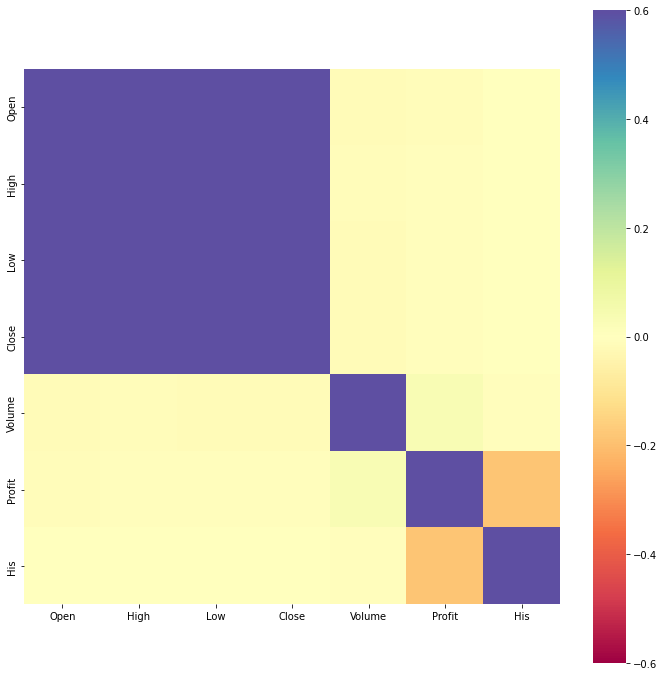

In [ ]:
# Tạo ra 2 cột mới trong đó cột Profit sẽ là giá trị cần dự đoán
def new_column(df, column, n):
    # Cột Profit là trênh lệch giá giữa 2 mốc thời gian liên tiếp
    df['Profit'] = -df[column].diff(periods=-1)

    # Cột His là trung bình lãi của n khoảng thời gian trươc đó
    df['His'] = df['Profit'].shift(1)
    for i in range(2,n):
        df['His'] = df['His'] + df['Profit'].shift(n)
    df['His'] = df['His']/n

    # Nhãn có thể được tạo ra (nếu Profit > 0 nhãn bằng 1) có thể được sử dụng cho bài toán phân lớp
    # df['Profitable'] = df['Profit'] > 0
    return df

# hiển thị ma trận tương quan
def show_correlation_value(df, method_id):
    # Sẽ có 3 phương thức tính toán tùy vào mô hình ta sử dụng
    method = ['pearson', 'kendall', 'spearman']
    C_mat = df.corr(method=method[method_id])
    fig = plt.figure(figsize = (12,12))

    print(C_mat)
    sb.heatmap(C_mat, square = True, vmax = 0.6, vmin = -0.6, cmap="Spectral")
    plt.show()

VIC_c = VIC.copy()
show_correlation_value(new_column(VIC_c, 'Open', 3),2)

Bảng bổ xung thêm 2 cột 
* **Profit**: Mức chênh lệch giá giữa thời điểm hiện tại và thời điểm kế tiếp
* **His**: Trung bình lãi/lỗ của n khoảng thời gian trươc đó

Mức độ tương quan hiện đang rất thấp trong khi 4 chỉ số Open, High, Low, Close đang có mức độ tương quan quá cao với nhau.
Em sẽ thay thế chúng bằng các chỉ số khác thể hiện sự chênh lệch vì mỗi mã có một mức hấp dẫn khác nhau nên ta không thể sử dụng trực tiếp giá như là một đặc trưng để dự đoán thị trường được.

Ngoài ra dữ liệu hiện tại tính theo phút và chỉ có 4 giao dịch (mở đầu, cao nhất, thấp nhất cả cuối cùng) nên tỉ lệ gặp nhiễu là rất cao. Chính vì thế em sẽ tính toán các giao dịch theo ngày.

          Volume     Value       Std      Open     Close      High       Low  \
Volume  1.000000 -0.136333  0.411806  0.000184  0.201923  0.404166 -0.377155   
Value  -0.136333  1.000000 -0.077384  0.028668 -0.108350 -0.197680  0.076226   
Std     0.411806 -0.077384  1.000000 -0.108267  0.098648  0.734925 -0.748791   
Open    0.000184  0.028668 -0.108267  1.000000 -0.156455  0.126675  0.248470   
Close   0.201923 -0.108350  0.098648 -0.156455  1.000000  0.221459  0.039037   
High    0.404166 -0.197680  0.734925  0.126675  0.221459  1.000000 -0.398479   
Low    -0.377155  0.076226 -0.748791  0.248470  0.039037 -0.398479  1.000000   
ATR     0.335057 -0.288419  0.380223 -0.050394  0.074414  0.388078 -0.369834   
Log    -0.064070  0.088544 -0.074428  0.230077 -0.519351 -0.155846 -0.005696   
Profit  0.063757 -0.087246  0.073606 -0.230701  0.521575  0.153013  0.003857   
His     0.010137  0.030298  0.035433 -0.427640  0.092929 -0.137702 -0.168611   

             ATR       Log    Profit   

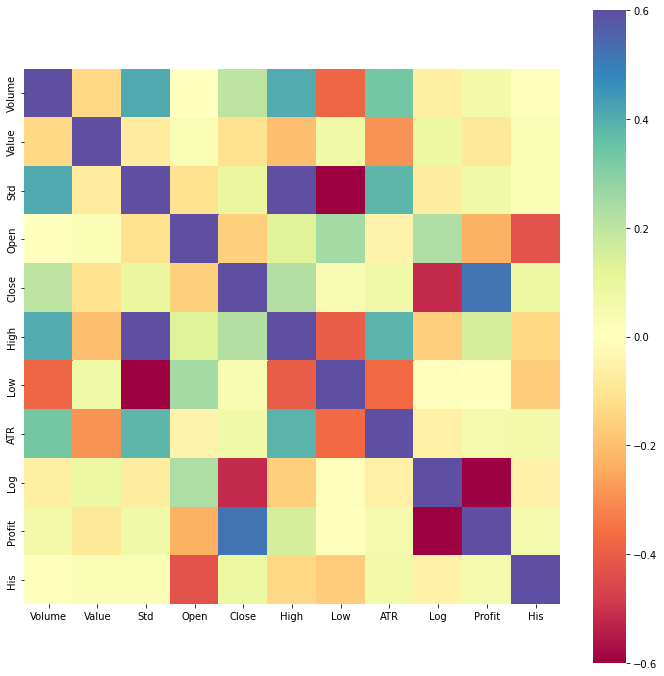

In [ ]:
# Nhóm cá giao dịch trong ngày
def group_by_day(df):
    # Ta sẽ coi tất cả giao dịch mà chúng ta có là như nhau và chuyển chúng thành một cột lấy tên là Value
    df = df.melt(id_vars=["Ticker", "Date/Time", 'Volume'], 
            var_name="Name", 
            value_name="Value")
    df = df.drop(columns=['Name'])

    # ta sẽ lấy mean của tất cả giao dịch trong ngày
    out = df.groupby([df['Date/Time'].dt.date]).mean()

    #lấy phương sai các giao dịch
    out['Std'] = df.groupby([df['Date/Time'].dt.date])['Value'].std()

    # Lấy các giá trị Open, Close, High, Low mới nhưng đồng thời so sánh chúng với giá trị mean
    out['Open']     = df.groupby([df['Date/Time'].dt.date])['Value'].first()    - out['Value']
    out['Close']    = df.groupby([df['Date/Time'].dt.date])['Value'].last()     - out['Value']
    out['High']     = df.groupby([df['Date/Time'].dt.date])['Value'].max()      - out['Value']
    out['Low']      = df.groupby([df['Date/Time'].dt.date])['Value'].min()      - out['Value']
    
    # Tính chỉ số ATR. Em chưa tìm hiểu sâu về chỉ số này lắm nên không rõ tính đúng không
    high_low = out['High'] - out['Low']
    high_close = np.abs(out['High'] - out['Close'].shift())
    low_close = np.abs(out['Low'] - out['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    out['ATR'] = (true_range.rolling(14).sum()/14).fillna(2.26)

    # Tính tỉ lệ lợi nhuận với ngày hôm sau (tỉ lệ này có thể được sử dụng làm nhãn dự đoán)
    out['Log'] = out['Value']/out['Value'].shift(-1)
    return out

def group(df):
    df = group_by_day(df)
    df = new_column(df, 'Value', 2)
    return df

# ALL = pd.concat((group(PNJ), group(SSI), group(MBB), group(VIC)))
VIC_c = VIC.copy()
show_correlation_value(group(VIC_c),2)
# group(VIC_c).describe()
# print(group(VIC_c))

Dữ liệu đã có nhiều thông tin hơn rõ rệt. 2 Giá trị dự đoán có thể là Profit hoặc Log. Ý nghĩa của các cột được viết ở đoạn mã phía trên

## Tìm chu kỳ dữ liệu

Ta sẽ sử dụng thư viện statsmodels để tìm xem liệu dữ liệu có chu kỳ nào không

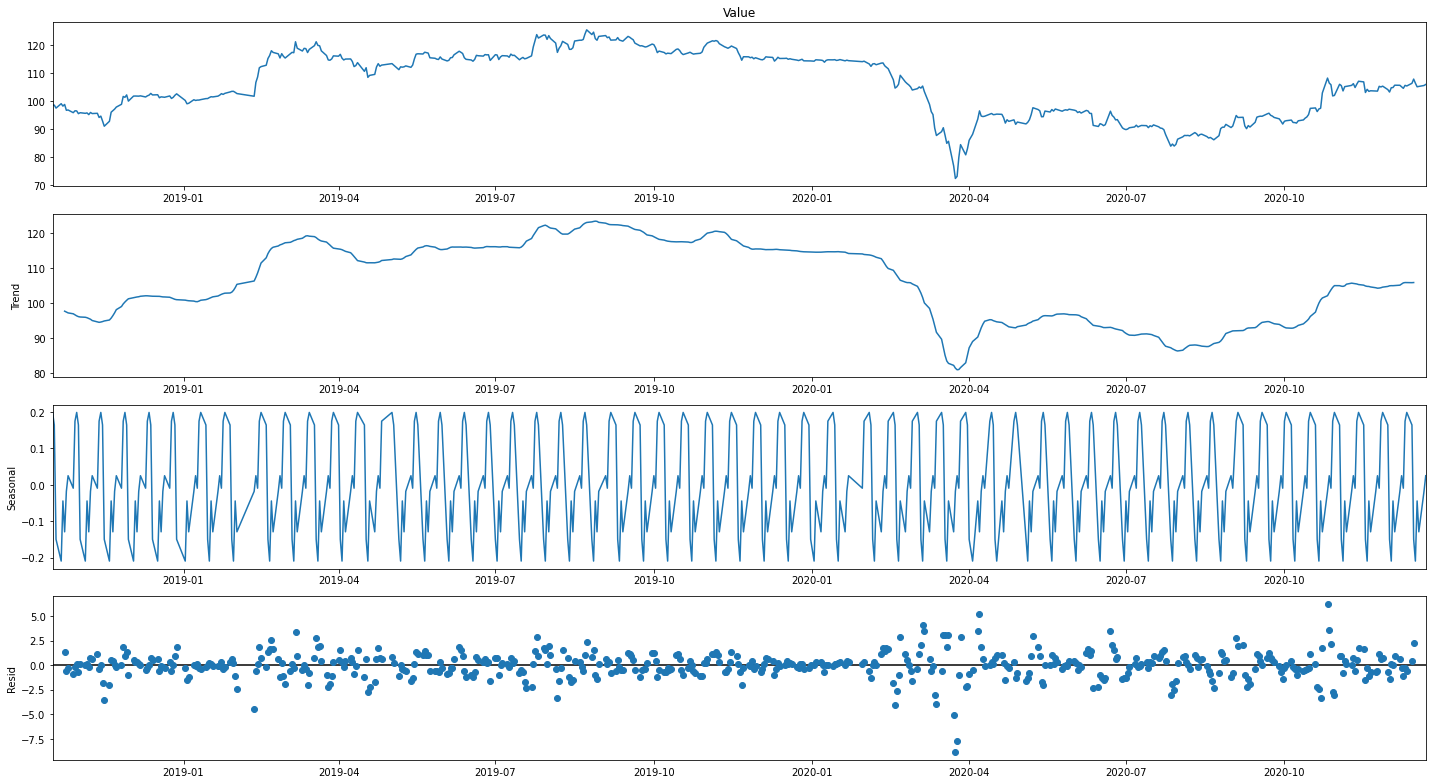

In [ ]:
VIC2 = group(VIC.copy())['Value']
de = sm.tsa.seasonal_decompose(VIC2, model = 'additive', period = 10)

plt.rcParams['figure.figsize'] = [20, 11]
fig = de.plot()
plt.show()

Mô hình này sẽ nhóm các ngày lại với nhau (period) 

Hình Seasonal là chu kỳ mà mô hình này tìm được. Sau khi chỉnh một hồi thì em không tìm được một chu kỳ rõ ràng nào cả

## Tìm mối quan hệ giữa các mã cố phiếu

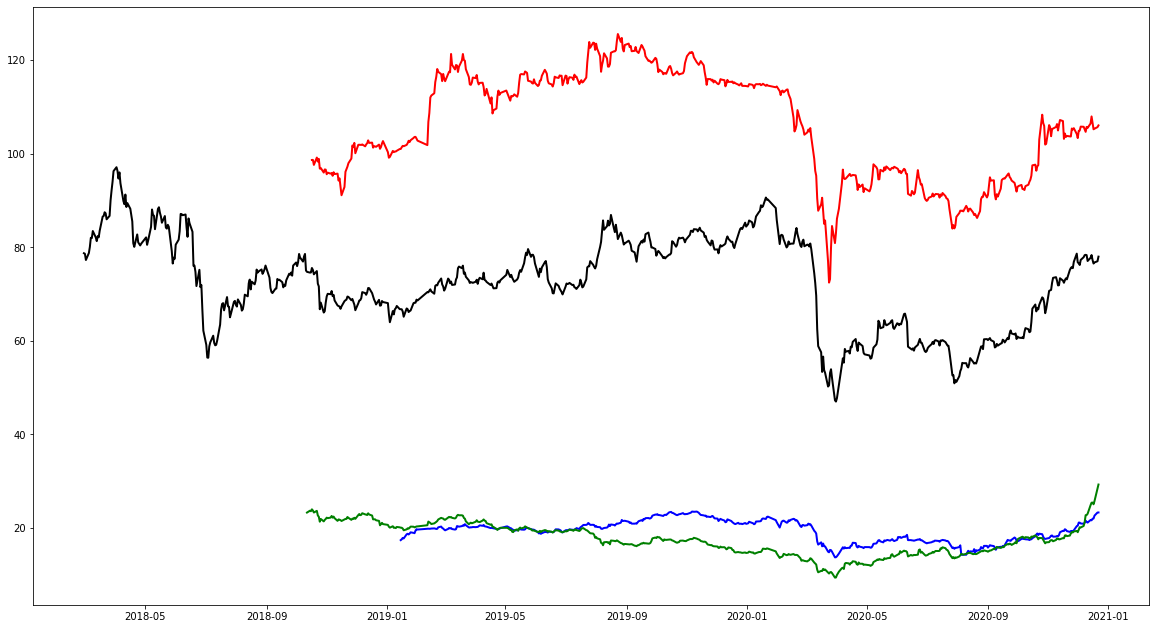

In [ ]:
VIC2 = group(VIC)
PNJ2 = group(PNJ)
MBB2 = group(MBB)
SSI2 = group(SSI)

fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [15, 10]
ax.plot(VIC2['Value'], linewidth=2.0, color='red')
ax.plot(MBB2['Value'], linewidth=2.0, color='blue')
ax.plot(SSI2['Value'], linewidth=2.0, color='green')
ax.plot(PNJ2['Value'], linewidth=2.0, color='black')
plt.show()


*   Đỏ: VIC
*   Lam: MBB
*   Lục: SSI
*   Đen: PNJ


Ta thấy dữ liệu phân bố không đều, có mã VIC và PNJ cao vượt trội so với 2 mã còn lại. Chính vì thế việc sử dụng giá trị Log (ở bảng trên) có vẻ là một lựa chọn hợp lý nếu muốn tạo một mô hình phù hợp với tất cả mã cổ phiếu.

4 mã cổ phiếu không thể đại diện cho cả thị trường. Và với sự trênh lệch về thời gian, em không tìm được một đặc trưng nào có thể khai thác từ chúng.

Nên ta có 2 lựa chọn. Xây dựng mỗi mã một mô hình hoặc một mô hình (sử dụng Profit) cho tất cả mã (sử dụng Log)

## Huấn luyện và kiểm tra

Em sẽ sử dụng một số mô hình ML cho bài toán so sánh chúng với nhau và sau đó thử nghiệm với một mô hình DL đơn giản.

### kiểm tra phân phối dữ liệu trước khi huấn luyện

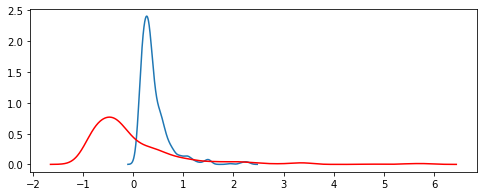

In [ ]:
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.preprocessing import StandardScaler

fig, ax = plt.subplots()
kde = KDEUnivariate(VIC2.Std)
kde.fit()
plt.plot(kde.support, kde.density)

a = StandardScaler().fit_transform(VIC2[['Std']])
kde = KDEUnivariate(a)
kde.fit()
plt.plot(kde.support, kde.density, color = "red")
plt.rcParams['figure.figsize'] = [8, 3]
plt.show()

### Chọn một số mô hình học máy để huấn luyện và đánh giá

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

scaler = StandardScaler()

In [ ]:
# Tạo ra một bộ dữ liệu huấn luyện
def get_dataset(df, scale, r = True):

    # có 3 giá trị nan ở His, Profit và Log, chyển tất cả về 0 cho an toàn
    df = df.fillna(0)
    X = scaler.fit_transform(df[['Volume','Value','Std','Open','Close','High','Low','ATR','His']])

    # Chọn giá trị dự đoán
    if r:
        y = scaler.fit_transform(df[['Profit']]).ravel()
        # y = scaler.fit_transform(df[['Log']]).ravel()
    else:
        y = scaler.fit_transform(df[['Profit']])
        # y = scaler.fit_transform(df[['Log']])

    # Tách dữ liệu. Ta sẽ lấy dữ liệu huấn luyện và kiểm tra liền mạnh do dữ liệu có sự tuần tự
    pos = int(scale*(len(X)))
    X_train = X[:pos]
    y_train = y[:pos]

    X_test = X[pos:-1]
    y_test = y[pos:-1]
    return X_train, y_train, X_test, y_test

# Huấn luyện mô hình.
def train_ml(model, df, scale):
    X_train, y_train, X_test, y_test = get_dataset(df, scale)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    count = 0
    for i in range(len(pred)):
        if pred[i] * y_test[i] > 0:
            count+= 1

    # Đánh giá
    return mean_squared_error(pred, y_test), count/len(pred)


# Gộp chung dữ liệu của tất cả các mã
ALL2 = pd.concat((SSI2, MBB2, VIC2, PNJ2))
# ALL2.describe()

dfs =[VIC2, MBB2, SSI2, PNJ2, ALL2]
models = [KNN(n_neighbors=4), 
          SVR(C=10.0), 
          Ridge(alpha=1.0),
          Lasso(),
          BayesianRidge(),
          LinearRegression()]

result = pd.DataFrame()
dfs_l = ['VIC', 'MBB','SSI', 'PNJ', 'ALL']
result['Model'] = ['KNN', 'SVR', 'Ridge', 'Lasso', 'BR', 'LR']
result.set_index('Model')

for d_i, d in enumerate(dfs):
    col = []
    for m_i,m in enumerate(models):
        mse_, acc = train_ml(m, d, 0.8)

        col.append(mse_)
        # col.append(acc)
    result[dfs_l[d_i]] = col

print(result)



   Model       VIC       MBB       SSI       PNJ       ALL
0    KNN  0.647230  1.154230  1.619570  0.481939  1.033037
1    SVR  0.723701  0.947287  1.682867  0.567562  1.060004
2  Ridge  0.455066  3.378702  1.219672  0.404992  0.885431
3  Lasso  1.077664  1.122971  1.843375  0.627491  1.378617
4     BR  0.463157  3.053468  1.249074  0.403807  0.884926
5     LR  0.454663  3.476018  1.218489  0.405059  0.885481


Mô hình Ridge tỏ ra vượt trội ở cả 4 mã và cả bộ dữ liệu tổng hợp theo giá trị **mean squared error**

### Xây dựng mô hình học sâu

Em mẽ sử dụng pytorch



In [ ]:
import os
import sys
import time
import random
import argparse

import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

random_seed = 1111
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

cudnn.benchmark = True
cudnn.deterministic = True

Em đã sử dụng bộ dữ liệu như trên và giá trị mean squared error hội tụ ở 1.0829. Em sẽ thay đổi bộ dữ liệu. Thay vì chỉ sử dụng 9 đặc trưng của từng ngày, em sẽ tăng số đặc trưng lên 39 (9+6*5) đặc trưng trong đó 30 đặc trưng là các giá trị Open, Close, High, Low, Std của 6 ngày trước đó.

In [ ]:
def get_dataset_dl(df, scale):

    training_df = df[['Volume','Value','Std','Open','Close','High','Low','ATR','His']]

    # Tăng số đặc trưng
    new_df = training_df[['Std','Open','Close','High','Low']].copy()
    new_df = new_df.shift()
    for _ in range(6):
        training_df = pd.merge(training_df, new_df, left_index=True, right_index=True, how="inner")
        new_df = new_df.shift()

    training_df = training_df.fillna(0)
    X = scaler.fit_transform(training_df)

    # Chọn giá trị dự đoán
    y = scaler.fit_transform(df[['Profit']])

    # Tách dữ liệu. Ta sẽ lấy dữ liệu huấn luyện và kiểm tra liền mạnh do dữ liệu có sự tuần tự
    pos = int(scale*(len(X)))
    X_train = torch.Tensor(X[:pos])
    y_train = torch.Tensor(y[:pos])

    X_test = torch.Tensor(X[pos:-1])
    y_test = torch.Tensor(y[pos:-1])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_dataset_dl(VIC2.copy(), 0.8)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=100)

<ipython-input-25-e5d652e52511>:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Low_x', 'Std_x', 'Close_x', 'Open_x', 'High_x'} in the result is deprecated and will raise a MergeError in a future version.
  training_df = pd.merge(training_df, new_df, left_index=True, right_index=True, how="inner")


In [ ]:
# xây dựng một mô hình ANN đơn giản. Mô hình này chưa được tinh chỉnh nhiều
class Model(nn.Module):
  def __init__(self, input_dim):
    super(Model, self).__init__()

    self.ANN = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(64, 64),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            # nn.Linear(128, 64),
            # nn.ReLU(True),
            nn.Linear(64, 1))

  def forward(self, input):
     return self.ANN(input)

# Khởi tạo mô hinhg
model = Model(len(X_train[0]))

model = torch.nn.DataParallel(model).to(device)
model.train()
print(model)

# Ta sẽ dùng MSE loss như phần trên
criterion = torch.nn.MSELoss()

filtered_parameters = []
for p in filter(lambda p: p.requires_grad, model.parameters()):
    filtered_parameters.append(p)

# Hàm tối ưu
optimizer = optim.Adam(filtered_parameters, lr=0.1)

DataParallel(
  (module): Model(
    (ANN): Sequential(
      (0): Linear(in_features=39, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


In [ ]:
iteration = 0
loss = 0

# Bắt đầu huấn luyện
while(iteration < 2000):
    for X, y in train_dataloader:
        iteration += 1

        preds = model(X)
        
        cost = criterion(preds, y)
        loss += cost

        model.zero_grad()
        cost.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        # Test mô hình
        if (iteration) % 100 == 0:
            model.eval()
            with torch.no_grad():  
                preds_v = model(X_test)
                cost = criterion(preds_v, y_test)
            model.train()

            print(f'[{iteration}] \t train_MSELoss: {loss/100} \t\t test_MSELoss: {cost}')
            loss = 0

[100] 	 train_MSELoss: 1.5326476097106934 		 test_MSELoss: 1.080706238746643
[200] 	 train_MSELoss: 0.9885103702545166 		 test_MSELoss: 1.081473708152771
[300] 	 train_MSELoss: 0.9712031483650208 		 test_MSELoss: 1.0817135572433472
[400] 	 train_MSELoss: 1.2910244464874268 		 test_MSELoss: 1.081488847732544
[500] 	 train_MSELoss: 1.0080066919326782 		 test_MSELoss: 1.0815399885177612
[600] 	 train_MSELoss: 0.9675655364990234 		 test_MSELoss: 1.081574559211731
[700] 	 train_MSELoss: 0.9982773661613464 		 test_MSELoss: 1.0849769115447998
[800] 	 train_MSELoss: 0.9636386036872864 		 test_MSELoss: 1.0840446949005127
[900] 	 train_MSELoss: 1.4345289468765259 		 test_MSELoss: 1.081748366355896
[1000] 	 train_MSELoss: 0.9642207622528076 		 test_MSELoss: 1.0822924375534058
[1100] 	 train_MSELoss: 1.0366073846817017 		 test_MSELoss: 1.0816864967346191
[1200] 	 train_MSELoss: 0.963656485080719 		 test_MSELoss: 1.0816013813018799
[1300] 	 train_MSELoss: 0.9788135290145874 		 test_MSELoss: 1.08164

Kết quả không được cải thiện nhiều lắm. Ngoài ra một số mã như MBB có loss tương đối cao (tương tự với các mô hình ML). Mô hình này còn thể được tinh chỉnh thêm về learning rate hay số lượng đặc trưng các layer,...